In [35]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [36]:
RS = 42

In [37]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=RS, train_size=0.8)
cnt_1 = y_train[y_train == 1].size
cnt_0 = y_train[y_train == 0].size
weight_for_1 = cnt_0 / cnt_1
weight_for_1

8.870324662996014

## 1. Влияние весов классов на метрики

In [38]:

params = {"max_depth": 5, "max_iter": 300, "learning_rate": 0.01}


# weights = [weight_for_1 * i for i in [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]]

weights = [weight_for_1 * (i / 100) for i in range(20, 200, 1)]


draw_data = []

for _weight_for_1 in weights:

  class_weight = {0: 1, 1: _weight_for_1}

  clf = HistGradientBoostingClassifier(**params, class_weight=class_weight)

  clf.fit(X_train, y_train)

  pred = clf.predict(X_test)

  metrics(pred, y_test, output=False)
  
  draw_data.append(metrics(pred, y_test, output=False))
  draw_data[-1]["Weight"] = _weight_for_1

Best weight for F1 score: 3.814239605088286. 
Best F1 score: 0.5970558028072578


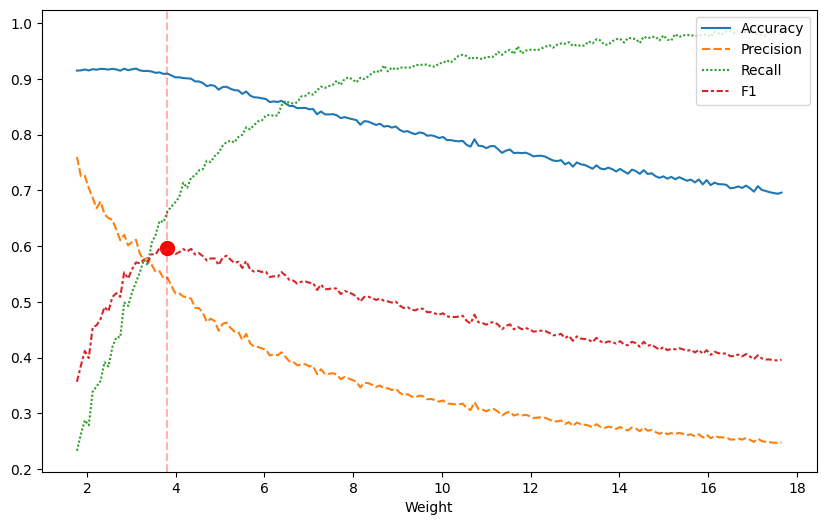

In [39]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Weight"])

best_weight_f1 = draw_df["F1"].idxmax()
best_f1 = draw_df["F1"].max()

print(f"Best weight for F1 score: {best_weight_f1}. \nBest F1 score: {best_f1}")

# Create plot with logarithmic x-axis
plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df)

plt.legend(loc="upper right")

# Highlight the best point
ax.axvline(x=best_weight_f1, color='red', linestyle='--', alpha=0.3)
ax.scatter(x=best_weight_f1, y=best_f1, color='red', s=100)

plt.show()



#### Видно, что веса довольно сильно влияют

## 2. Лучший Learning rate

In [40]:

weight_for_1 = best_weight_f1

class_weight = {0: 1, 1: weight_for_1}

params = {"max_depth": 5, "max_iter": 300, "class_weight": class_weight}

draw_data = []

for lr in [i / 1000 for i in range(1, 1000, 10)]:

  clf = HistGradientBoostingClassifier(**params, learning_rate=lr)

  clf.fit(X_train, y_train)

  pred = clf.predict(X_test)

  metrics(pred, y_test, output=False)
  
  draw_data.append(metrics(pred, y_test, output=False))
  draw_data[-1]["Learning rate"] = lr

Best learning rate for F1 score: 0.231
Best F1 score: 0.7645


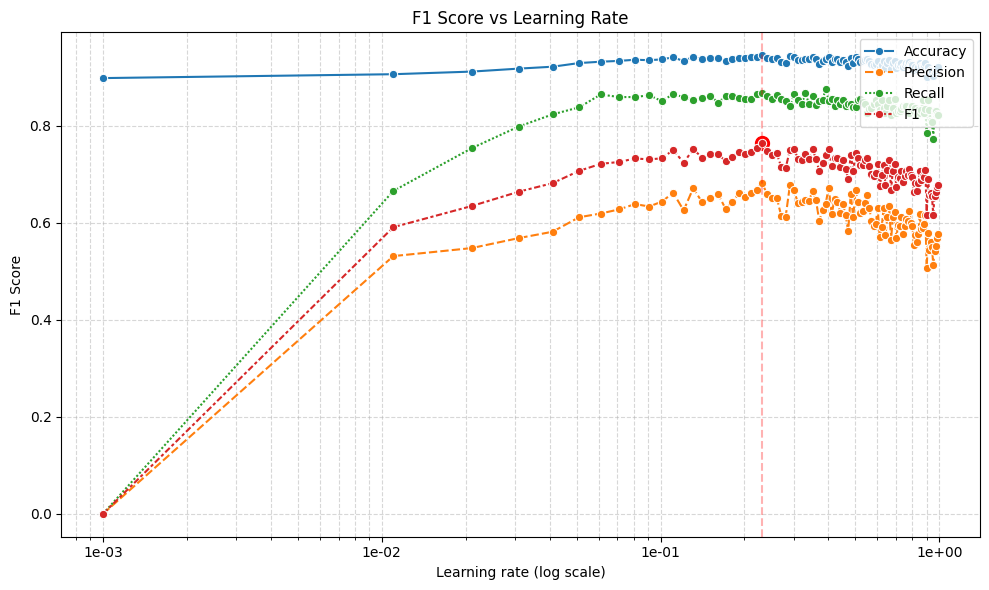

In [44]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index("Learning rate")

# Find best learning rate
best_lr = draw_df['F1'].idxmax()
best_f1 = draw_df['F1'].max()

print(f"Best learning rate for F1 score: {best_lr}\nBest F1 score: {best_f1:.4f}")

plt.figure(figsize=(10, 6))
ax = sns.lineplot(data=draw_df, marker='o')

ax.set_xscale('log')
ax.set_xlabel('Learning rate (log scale)')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score vs Learning Rate')

ax.axvline(x=best_lr, color='red', linestyle='--', alpha=0.3)
ax.scatter(x=best_lr, y=best_f1, color='red', s=100)

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Improve tick formatting
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Accuracy:   0.9433715472801416
Precision:  0.6753168376584189
Recall:     0.8496583143507973
F1:         0.7525218560860794


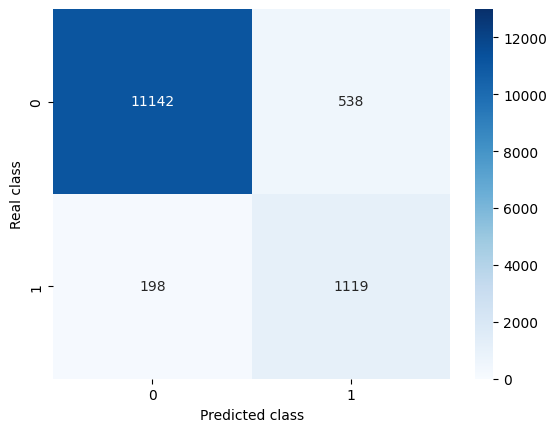

{'Accuracy': 0.9433715472801416,
 'Precision': 0.6753168376584189,
 'Recall': 0.8496583143507973,
 'F1': 0.7525218560860794}

In [43]:
params = {"max_iter": 300, "max_depth": 5, "learning_rate": best_lr, "class_weight": {0: 1, 1:best_weight_f1}}

clf = HistGradientBoostingClassifier(**params)

clf.fit(X_train, y_train)

pred = clf.predict(X_test)

metrics(pred, y_test)
